# About

- In this notebook we train Yolo model to detect PPE (Personal Protective Equipment) on a small dataset provided by [APTAR](https://aptar.com/) for a hackathon challenge.

- Labels in this dataset:
    - 0: Helmet
    - 1: Safety_Goggles
    - 2: Vest
    - 3: Hairnet
    - 4: Earplug
    - 5: No_Helmet
    - 6: No_Safety_Goggles
    - 7: No_Vest 
    - 8: No_Hairnet
    - 9: No_Earplug
    - 10: Person

- More info:
    - Number of classes: 10
    - Label Annotation: YOLO format (.txt)
      - `[class_id, center_x, center_y, width, height]`
      
___      

Yolo Dataset folder structure: the paths to these folders will be written to a YAML file that will be used by Yolo.

```
Custom dataset directory (root)
    - train
        - images (folder including all training images)
        - labels (folder including all training labels)
    - validation
        - images (folder including all validation images)
        - labels (folder including all validation labels)
    - test
        - images (folder including all test images)
        - labels (folder including all test labels)

```

# Imports

In [1]:
import ultralytics
print(ultralytics.__version__)

8.1.29


In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

# CFG

- CFG class enables easy and organized experimentation
- Set `DEBUG = True` to make quick experiments

In [46]:
folder_path = "datasets/annotated_dataset"

In [47]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    with open(os.path.join(folder_path, 'classes.txt'), 'r') as file:
        CLASSES = [line.strip() for line in file.readlines()]
    NUM_CLASSES_TO_TRAIN = len(CLASSES)
    print(f'Classes: {CLASSES}')

    # training
    EPOCHS = 3 if DEBUG else 20 # 100
    BATCH_SIZE = 16

    BASE_MODEL = 'yolov8s' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 5
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    CUSTOM_DATASET_DIR = folder_path
    OUTPUT_DIR = './'

Classes: ['Helmet', 'Safety_Goggles', 'Vest', 'Hairnet', 'Earplug', 'No_Helmet', 'No_Safety_Goggles', 'No_Vest', 'No_Hairnet', 'No_Earplug', 'Person']


# Create YAML file

- Create ```data.yaml``` file properly formatted to be used by Yolo

In [48]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train').removeprefix('datasets/'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid').removeprefix('datasets/'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test').removeprefix('datasets/'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [49]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Helmet
- Safety_Goggles
- Vest
- Hairnet
- Earplug
- No_Helmet
- No_Safety_Goggles
- No_Vest
- No_Hairnet
- No_Earplug
- Person
nc: 11
test: annotated_dataset/test
train: annotated_dataset/train
val: annotated_dataset/valid



# Dataset

- Check some images
- Image utils

## Visualize images from dataset

In [50]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

In [51]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

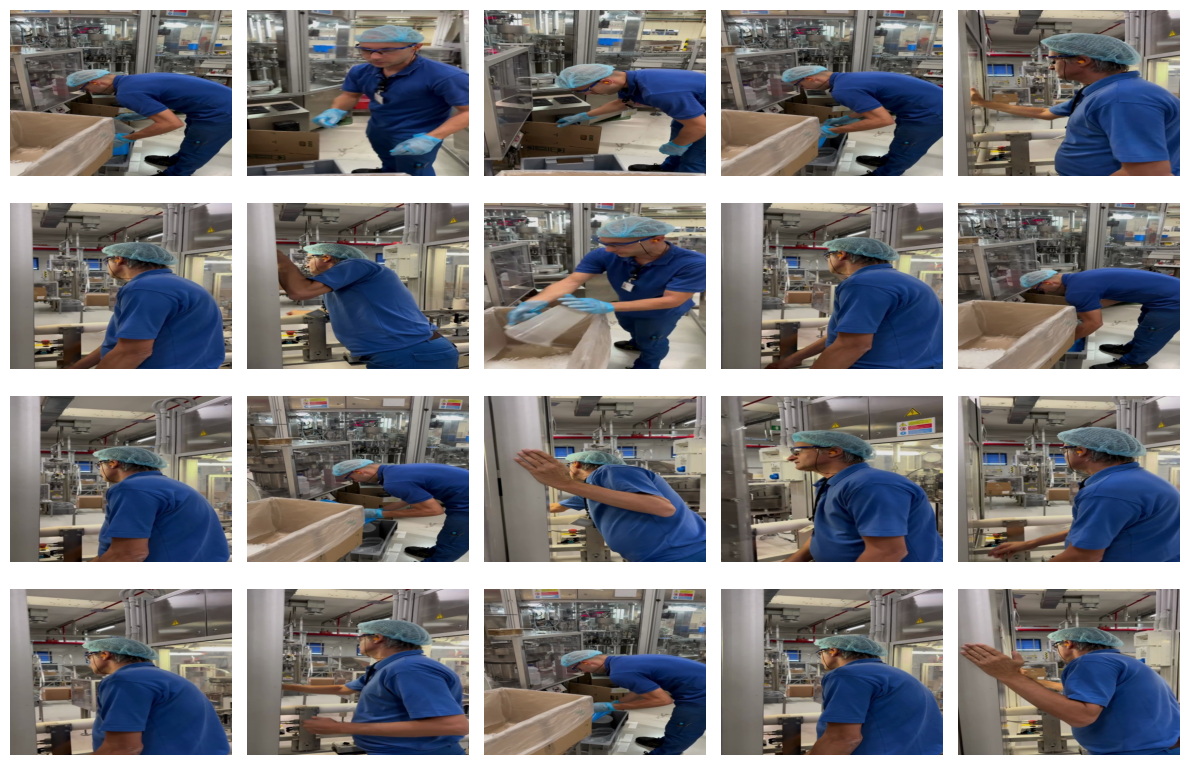

In [52]:
folder_path = CFG.CUSTOM_DATASET_DIR + '/train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)
# plot_random_images_from_folder(folder_path, num_images=20, seed=54)

## Image properties

In [53]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [59]:
# Get the properties of the first image in the training set
first_image_path = os.path.join(CFG.CUSTOM_DATASET_DIR, 'train/images', os.listdir(CFG.CUSTOM_DATASET_DIR + '/train/images/')[0])
img_properties = get_image_properties(first_image_path)
img_properties

{'width': 640, 'height': 480, 'channels': 3, 'dtype': dtype('uint8')}

## Dataset statistics

In [60]:
%%time

class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            cList1 = f.read().splitlines()

            for cls in set([line.split(' ')[0] for line in cList1]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 2.94 ms, sys: 7.35 ms, total: 10.3 ms
Wall time: 22.6 ms


,Mode,Helmet,Safety_Goggles,Vest,Hairnet,Earplug,No_Helmet,No_Safety_Goggles,No_Vest,No_Hairnet,No_Earplug,Person,Data_Volume
0,train,0,87,0,89,89,89,0,90,0,0,90,90
1,valid,0,5,0,5,5,5,0,5,0,0,5,5
2,test,0,5,0,5,5,5,0,5,0,0,5,5


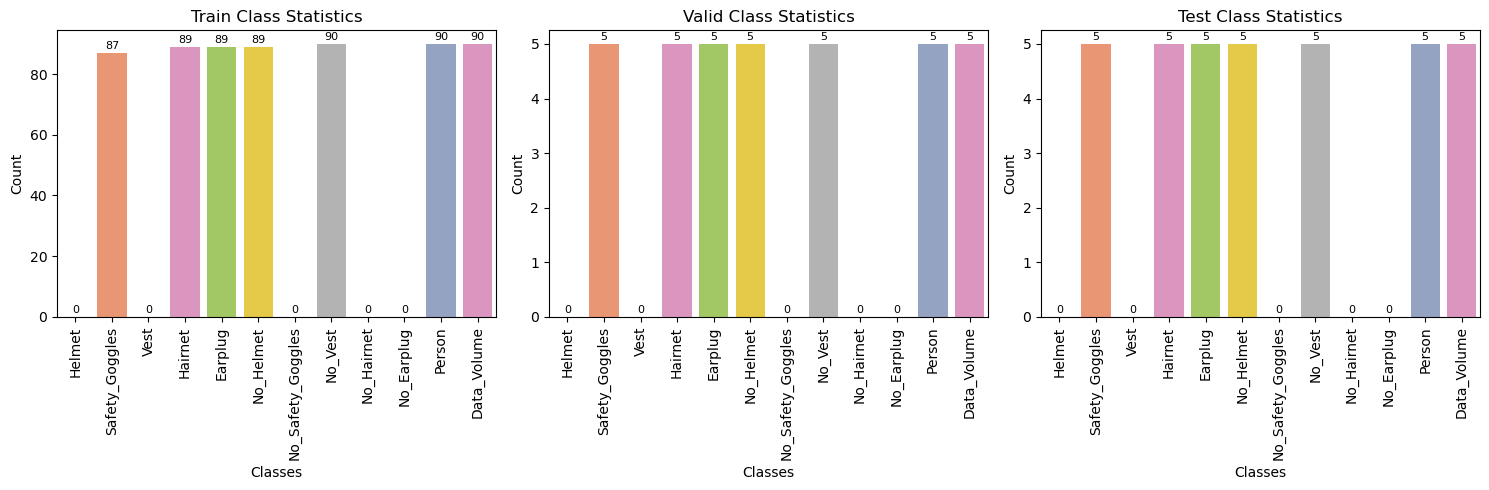

In [61]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

## Image sizes

In [62]:
%%time

for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 480)



Image sizes in valid set:
(640, 480)



Image sizes in test set:
(640, 480)


CPU times: user 7.16 ms, sys: 8.07 ms, total: 15.2 ms
Wall time: 31.2 ms


# Base Model Inference

- Just checking the power of the pretrained model inference on the CSS dataset

In [63]:
CFG.BASE_MODEL_WEIGHTS

'yolov8s.pt'

In [64]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [65]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

with tf.device('/GPU:0'):
    results = model.predict(
        source=first_image_path,
        classes=[0],
        conf=0.30,
        imgsz=(img_properties['height'], img_properties['width']),
        save=True,
        save_txt=True,
        save_conf=True,
        exist_ok=True,
    )


image 1/1 /Users/akbaig/Projects/Hackathon/PPE-Detection-YOLO/datasets/annotated_dataset/train/images/IMG_4501_frame_00370.jpg: 480x640 1 person, 98.8ms
Speed: 2.6ms preprocess, 98.8ms inference, 10.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (480, 640, 3) 



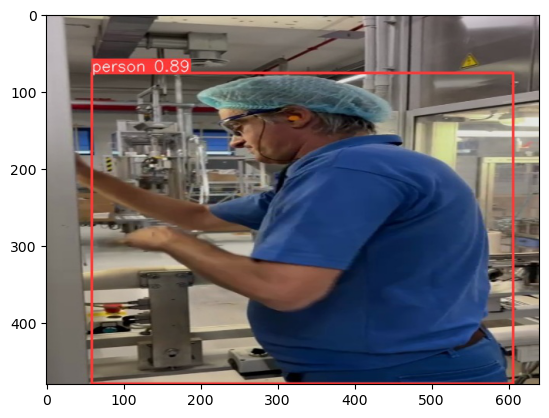

In [66]:
### check predictions with base model
example_image_inference_output = first_image_path.split('/')[-1]
display_image(f'runs/detect/predict/{example_image_inference_output}')

# Train

[Arguments for training](https://docs.ultralytics.com/modes/train/#arguments)

In [67]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov8s.pt
Epochs:  20
Batch:  16


In [68]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [69]:
%%time

### train
with tf.device('/GPU:0'):


  model.train(
      data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

      task = 'detect',

      imgsz = (img_properties['height'], img_properties['width']),

      epochs = CFG.EPOCHS,
      batch = CFG.BATCH_SIZE,
      optimizer = CFG.OPTIMIZER,
      lr0 = CFG.LR,
      lrf = CFG.LR_FACTOR,
      weight_decay = CFG.WEIGHT_DECAY,
      dropout = CFG.DROPOUT,
      fraction = CFG.FRACTION,
      patience = CFG.PATIENCE,
      profile = CFG.PROFILE,
      label_smoothing = CFG.LABEL_SMOOTHING,

      name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
      seed = CFG.SEED,

      val = True,
      amp = True,
      exist_ok = True,
      resume = False,
      verbose = False,
  )

New https://pypi.org/project/ultralytics/8.3.86 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.29 🚀 Python-3.9.19 torch-2.5.0 CPU (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=./data.yaml, epochs=20, time=None, patience=5, batch=16, imgsz=(480, 640), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_ppe_css_20_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fals

train: Scanning /Users/akbaig/Projects/Hackathon/PPE-Detection-YOLO/datasets/annotated_dataset/train/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 2772.12it/s]

train: New cache created: /Users/akbaig/Projects/Hackathon/PPE-Detection-YOLO/datasets/annotated_dataset/train/labels.cache



val: Scanning /Users/akbaig/Projects/Hackathon/PPE-Detection-YOLO/datasets/annotated_dataset/valid/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 4115.29it/s]

val: New cache created: /Users/akbaig/Projects/Hackathon/PPE-Detection-YOLO/datasets/annotated_dataset/valid/labels.cache
Plotting labels to runs/detect/yolov8s_ppe_css_20_epochs/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/yolov8s_ppe_css_20_epochs
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.548      3.941      1.735         91        640: 100%|██████████| 6/6 [01:14<00:00, 12.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all          5         30      0.641      0.313      0.399      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G       1.27      2.148      1.479        171        640: 100%|██████████| 6/6 [01:19<00:00, 13.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all          5         30      0.793      0.653      0.777      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      1.121      1.461      1.381         84        640: 100%|██████████| 6/6 [01:16<00:00, 12.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all          5         30      0.768      0.904      0.928      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      0.997      1.157      1.277        112        640: 100%|██████████| 6/6 [01:12<00:00, 12.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all          5         30      0.775      0.921      0.969      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G     0.9549      1.012      1.227        120        640: 100%|██████████| 6/6 [01:19<00:00, 13.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all          5         30      0.976          1      0.995       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G     0.9367     0.9222      1.208        129        640: 100%|██████████| 6/6 [01:19<00:00, 13.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all          5         30      0.957      0.997      0.995      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G     0.9098     0.8609      1.171        109        640: 100%|██████████| 6/6 [01:25<00:00, 14.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all          5         30      0.972          1      0.995      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G     0.8923        0.8      1.149        137        640: 100%|██████████| 6/6 [01:24<00:00, 14.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all          5         30      0.959      0.984      0.995      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G     0.8556     0.7539      1.141        115        640: 100%|██████████| 6/6 [01:26<00:00, 14.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all          5         30      0.956      0.987      0.995      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G     0.8595     0.7275       1.11         96        640: 100%|██████████| 6/6 [01:27<00:00, 14.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          5         30      0.952      0.992      0.995      0.749


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      0.932     0.9948      1.186         60        640: 100%|██████████| 6/6 [01:16<00:00, 12.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all          5         30      0.873      0.995      0.984      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G     0.9201     0.8469      1.196         59        640: 100%|██████████| 6/6 [01:18<00:00, 13.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all          5         30      0.978      0.976      0.995      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G       0.87     0.7647      1.145         56        640: 100%|██████████| 6/6 [01:20<00:00, 13.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all          5         30      0.959      0.971      0.995      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G     0.8642     0.7353      1.141         59        640: 100%|██████████| 6/6 [01:20<00:00, 13.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          5         30      0.954      0.976      0.995      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G     0.8289     0.7243      1.111         60        640: 100%|██████████| 6/6 [01:19<00:00, 13.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all          5         30      0.968      0.971      0.995      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G     0.8229     0.6836      1.099         60        640: 100%|██████████| 6/6 [01:22<00:00, 13.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all          5         30      0.969      0.972      0.995      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G     0.8041     0.6595      1.102         60        640: 100%|██████████| 6/6 [01:26<00:00, 14.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all          5         30      0.966      0.967      0.989       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G     0.8027     0.6443      1.102         60        640: 100%|██████████| 6/6 [01:17<00:00, 12.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all          5         30      0.952      0.994      0.995      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      0.748     0.6036      1.047         60        640: 100%|██████████| 6/6 [01:19<00:00, 13.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all          5         30      0.966      0.996      0.995      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G     0.7541     0.6116      1.039         60        640: 100%|██████████| 6/6 [01:20<00:00, 13.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all          5         30      0.971          1      0.995      0.776



20 epochs completed in 0.455 hours.
Optimizer stripped from runs/detect/yolov8s_ppe_css_20_epochs/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_ppe_css_20_epochs/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_ppe_css_20_epochs/weights/best.pt...


python(5439) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.29 🚀 Python-3.9.19 torch-2.5.0 CPU (Apple M2)
Model summary (fused): 168 layers, 11129841 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


                   all          5         30      0.971          1      0.995      0.776
Speed: 0.8ms preprocess, 130.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/yolov8s_ppe_css_20_epochs
CPU times: user 1h 29min 23s, sys: 19min 6s, total: 1h 48min 30s
Wall time: 27min 34s


# Export

- [Export mode](https://docs.ultralytics.com/modes/export/) is used for exporting a YOLOv8 model to a format that can be used for deployment. In this mode, the model is converted to a format that can be used by other software applications or hardware devices. This mode is useful when deploying the model to production environments.

In [70]:
img_properties

{'width': 640, 'height': 480, 'channels': 3, 'dtype': dtype('uint8')}

In [71]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.1.29 🚀 Python-3.9.19 torch-2.5.0 CPU (Apple M2)
Model summary (fused): 168 layers, 11129841 parameters, 0 gradients, 28.5 GFLOPs


python(5521) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



PyTorch: starting from 'runs/detect/yolov8s_ppe_css_20_epochs/weights/best.pt' with input shape (1, 3, 480, 640) BCHW and output shape(s) (1, 15, 6300) (21.5 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...


python(5526) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 44.5 MB/s eta 0:00:00a 0:00:01

requirements: AutoUpdate success ✅ 3.1s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: export success ✅ 4.3s, saved as 'runs/detect/yolov8s_ppe_css_20_epochs/weights/best.onnx' (42.6 MB)

Export complete (4.7s)
Results saved to /Users/akbaig/Projects/Hackathon/PPE-Detection-YOLO/runs/detect/yolov8s_ppe_css_20_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov8s_ppe_css_20_epochs/weights/best.onnx imgsz=480,640  
Validate:        yolo val task=detect model=runs/detect/yolov8s_ppe_css_20_epochs/weights/best.onnx imgsz=480,640 data=./data.yaml  WARNING ⚠️ non-PyTorch val requires square images, 'imgsz=[480, 640]' will not work. Use export 'imgsz=640' if val is required.
Visualize:       https://netron.app


'runs/detect/yolov8s_ppe_css_20_epochs/weights/best.onnx'

# Train results

In [72]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/yolov8s_ppe_css_20_epochs/confusion_matrix.png',
 './runs/detect/yolov8s_ppe_css_20_epochs/results.png',
 './runs/detect/yolov8s_ppe_css_20_epochs/P_curve.png',
 './runs/detect/yolov8s_ppe_css_20_epochs/F1_curve.png',
 './runs/detect/yolov8s_ppe_css_20_epochs/confusion_matrix_normalized.png',
 './runs/detect/yolov8s_ppe_css_20_epochs/R_curve.png',
 './runs/detect/yolov8s_ppe_css_20_epochs/PR_curve.png',
 './runs/detect/yolov8s_ppe_css_20_epochs/labels_correlogram.jpg',
 './runs/detect/yolov8s_ppe_css_20_epochs/labels.jpg']

./runs/detect/yolov8s_ppe_css_20_epochs/F1_curve.png


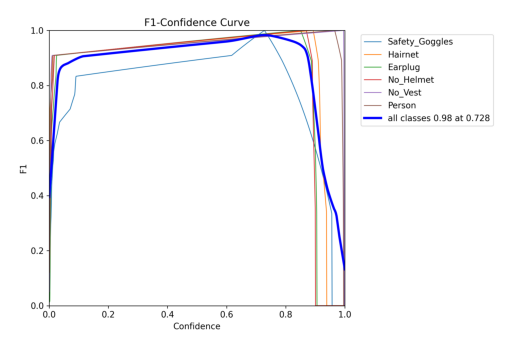



./runs/detect/yolov8s_ppe_css_20_epochs/PR_curve.png


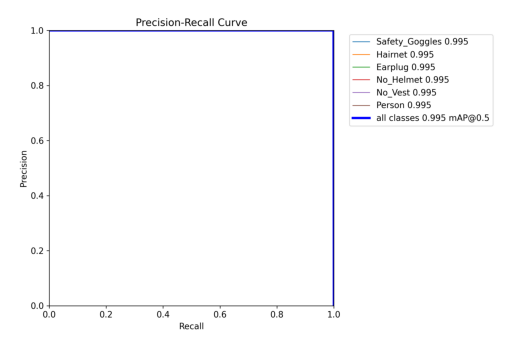



./runs/detect/yolov8s_ppe_css_20_epochs/P_curve.png


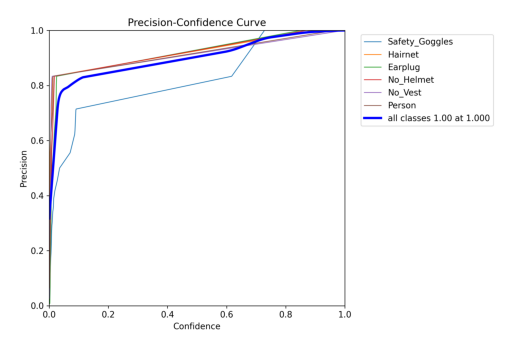



./runs/detect/yolov8s_ppe_css_20_epochs/R_curve.png


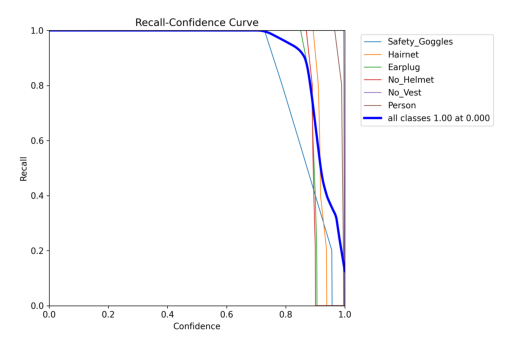



./runs/detect/yolov8s_ppe_css_20_epochs/confusion_matrix.png


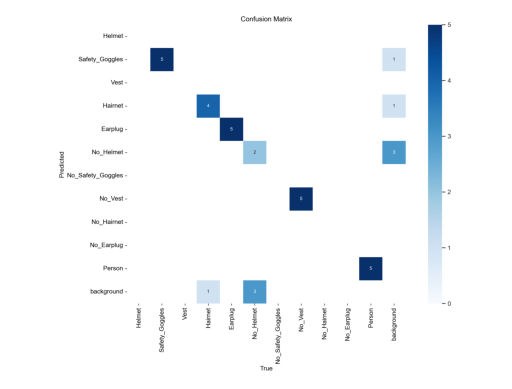



./runs/detect/yolov8s_ppe_css_20_epochs/confusion_matrix_normalized.png


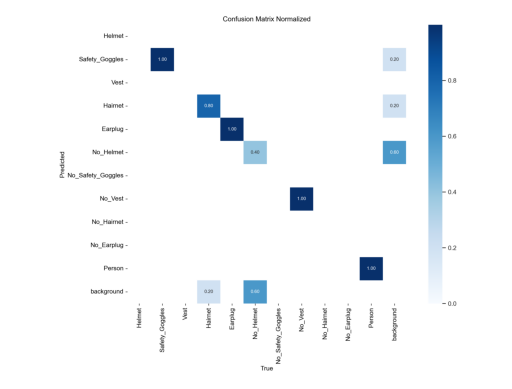



./runs/detect/yolov8s_ppe_css_20_epochs/labels.jpg


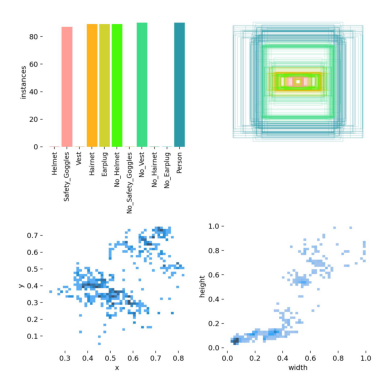



./runs/detect/yolov8s_ppe_css_20_epochs/labels_correlogram.jpg


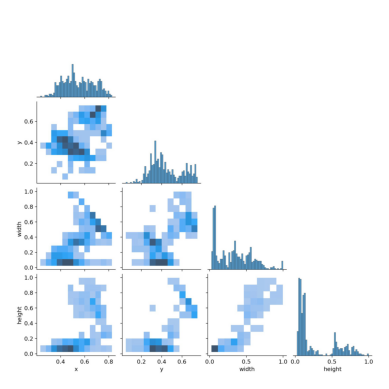



./runs/detect/yolov8s_ppe_css_20_epochs/results.png


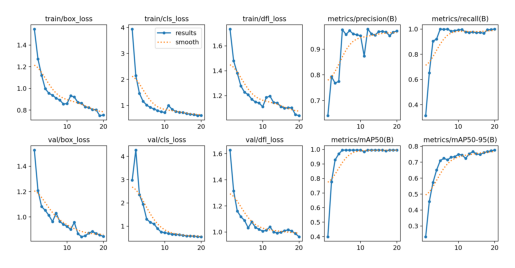

In [74]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

# Loss

- The loss function in YOLO consists of three main components: box loss, class loss (cls loss), and objectness loss (dfl loss).
- The total loss in YOLO is a combination of these three components

___

**Box loss:**
- The box loss measures how accurately the predicted bounding box coordinates match the ground truth bounding box.
- Is typically computed using a regression loss, such as Mean Squared Error (MSE), between the predicted bounding box coordinates (center coordinates, width, and height) and the ground truth bounding box coordinates.

___

**Class loss (cls):**
- The class loss measures how well the predicted class probabilities match the true class labels.
- The class loss is usually computed using a categorical cross-entropy loss, which penalizes the difference between the predicted class probabilities and the true class labels.

___

**Objectness loss (dfl):**
- Distribution Focal Loss
- YOLO predicts an "objectness" score for each bounding box, indicating the presence of an object within the grid cell. This score helps filter out irrelevant bounding boxes.
- The objectness loss is calculated based on the difference between the predicted objectness score and the ground truth objectness label. It penalizes the model for false positives and false negatives in predicting the presence of an object.

In [75]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.54760,3.94080,1.7354,0.64113,0.31328,0.39948,0.23220,1.52700,2.97430,1.62760,0.000033,0.000033,0.000033
1,2,1.27050,2.14760,1.4792,0.79298,0.65291,0.77685,0.45366,1.20840,4.27050,1.31400,0.000070,0.000070,0.000070
2,3,1.12070,1.46140,1.3814,0.76799,0.90388,0.92782,0.57238,1.08160,2.35760,1.16010,0.000102,0.000102,0.000102
3,4,0.99696,1.15710,1.2769,0.77472,0.92074,0.96889,0.65058,1.05210,1.94290,1.11700,0.000131,0.000131,0.000131
4,5,0.95486,1.01210,1.2271,0.97586,1.00000,0.99500,0.70966,1.01280,1.30020,1.08890,0.000155,0.000155,0.000155
5,6,0.93669,0.92221,1.2078,0.95708,0.99690,0.99500,0.72487,0.96347,1.16500,1.03220,0.000176,0.000176,0.000176
6,7,0.90983,0.86087,1.1708,0.97191,1.00000,0.99500,0.71480,1.03050,1.09400,1.07730,0.000192,0.000192,0.000192
7,8,0.89228,0.80001,1.1485,0.95895,0.98352,0.99500,0.73164,0.96398,0.89614,1.03550,0.000205,0.000205,0.000205
8,9,0.85559,0.75395,1.1407,0.95575,0.98689,0.99500,0.73443,0.94208,0.74497,1.02080,0.000214,0.000214,0.000214
9,10,0.85953,0.72751,1.1105,0.95193,0.99209,0.99500,0.74943,0.92579,0.72324,1.00640,0.000218,0.000218,0.000218


In [76]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.74803 , on epoch:  19 


Best Validation Box loss:  0.84408 , on epoch:  14 


Best Training Cls loss:  0.60362 , on epoch:  19 


Best Validation Cls loss:  0.54569 , on epoch:  20 


Best Training DFL loss:  1.0388 , on epoch:  20 


Best Validation DFL loss:  0.96374 , on epoch:  20 



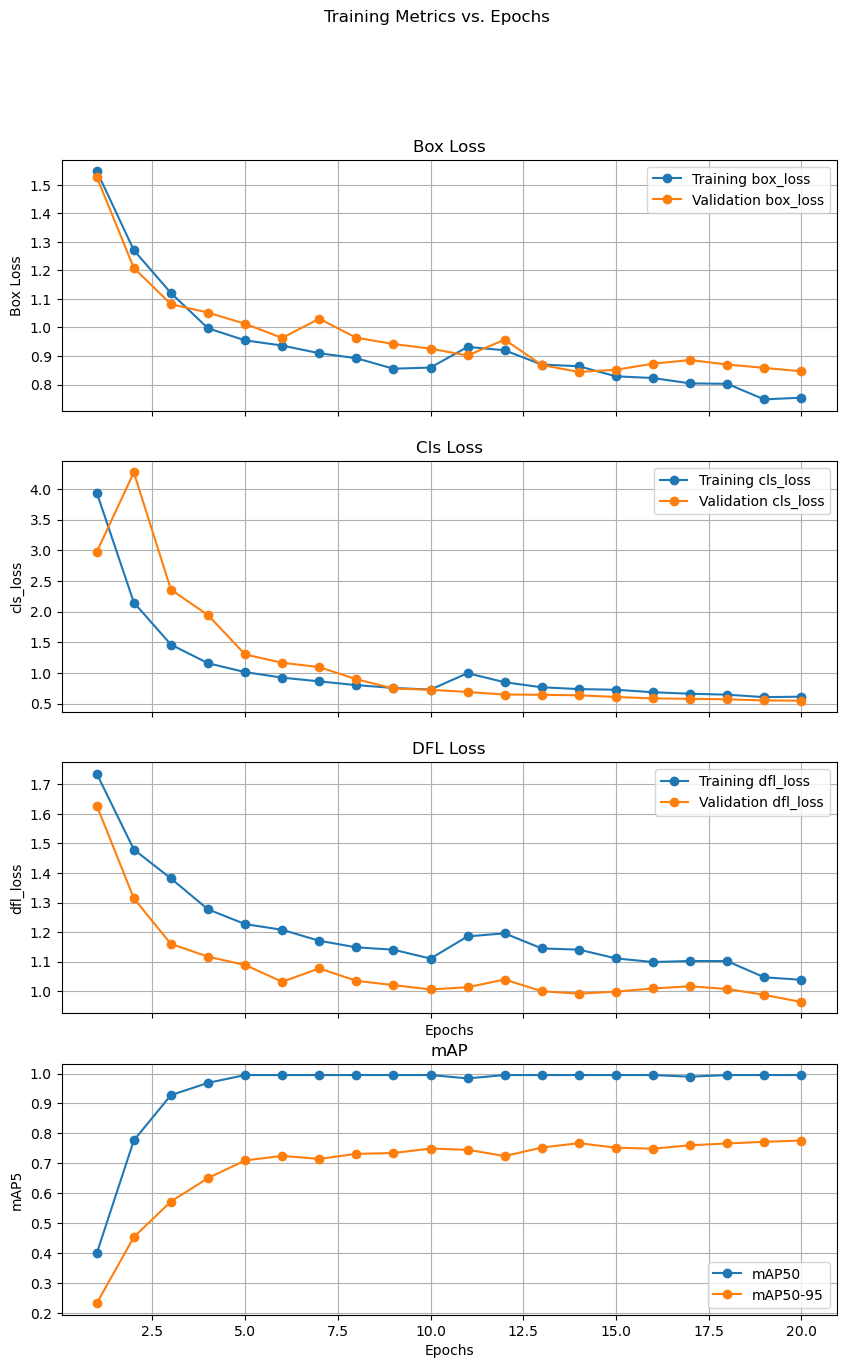

In [77]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

### Training and Validation dfl_loss
ax4.set_title('mAP')
ax4.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50', marker='o', linestyle='-')
ax4.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95', marker='o', linestyle='-')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('mAP5')
ax4.legend()
ax4.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

# Validation results

In [78]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

2

In [79]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

./runs/detect/yolov8s_ppe_css_20_epochs/val_batch0_pred.jpg


./runs/detect/yolov8s_ppe_css_20_epochs/val_batch0_pred.jpg


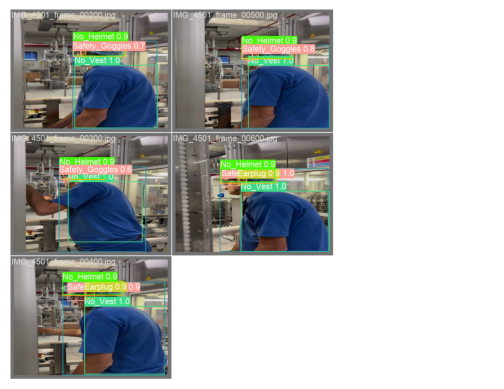

In [80]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)